In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

from numba import njit

## Loading the data and obtaining a sort of profile histogram

In [2]:
# Open the file and show its contents (like .ls in ROOT CERN)
t_hk_obox = ur.open("../data/Allaux_Bfield.root:t_hk_obox")
print(t_hk_obox.show())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
odd_index            | int32_t                  | AsDtype('>i4')
even_index           | int32_t                  | AsDtype('>i4')
odd_is_bad           | int32_t                  | AsDtype('>i4')
even_is_bad          | int32_t                  | AsDtype('>i4')
obox_is_bad          | int32_t                  | AsDtype('>i4')
packet_num           | uint16_t                 | AsDtype('>u2')
timestamp            | uint32_t                 | AsDtype('>u4')
obox_mode            | uint8_t                  | AsDtype('uint8')
cpu_status           | uint16_t                 | AsDtype('>u2')
trig_status          | uint8_t                  | AsDtype('uint8')
comm_status          | uint8_t                  | AsDtype('uint8')
ct_temp              | float                    | AsDtype('>f4')
chain_temp           | float                    | As

In [3]:
# Obtain a dictionary where keys are the names shown above and
# values are numpy arrays containing the data
t_hk_obox_dict = t_hk_obox.arrays(["saa", 
                  "fe_temp",
                  "glon", 
                  "glat",
                  "tunix",
                  "fe_cosmic",
                  "fe_rate"], library="np")

In [4]:
tunix = t_hk_obox_dict["tunix"]
sum_fe_rate = np.sum(t_hk_obox_dict["fe_rate"], axis=1)

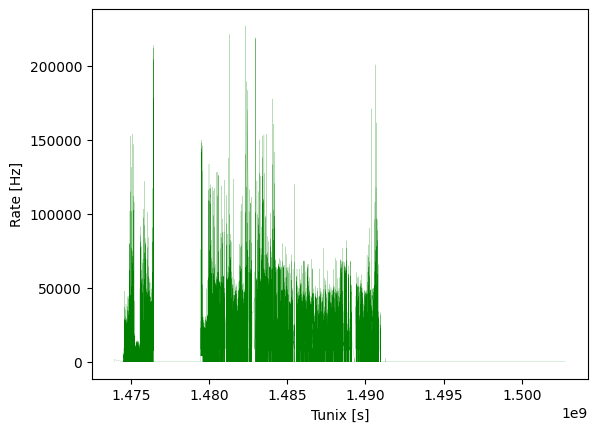

In [5]:
plt.plot(tunix, sum_fe_rate, 'g', linewidth=0.1)
plt.xlabel("Tunix [s]")
plt.ylabel("Rate [Hz]")  # nb. photons per seconds
plt.show()

Crop the right part (just visually, no formal reason why a particular threshold)

In [6]:
mask = tunix < 1.493*1e9
tunix = tunix[mask]
sum_fe_rate = sum_fe_rate[mask]

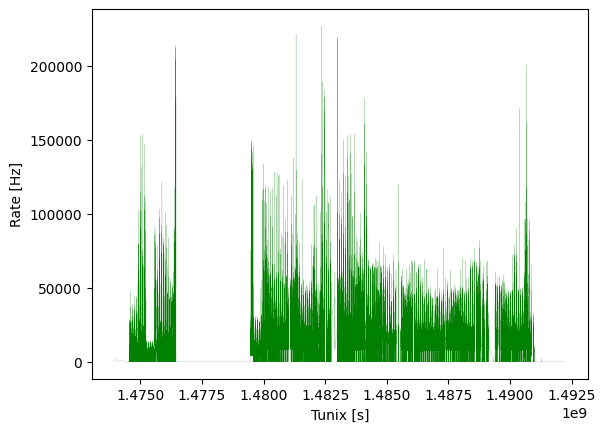

In [7]:
plt.plot(tunix, sum_fe_rate, 'g', linewidth=0.1)
plt.xlabel("Tunix [s]")
plt.ylabel("Rate [Hz]")  # nb. photons per seconds
plt.show()

We can observe a lot of missing values due to the detector being switched off when astronauts went onboard the space station. Small missing values are due to the South Altantic Anomaly region.

In [8]:
tunix_min = tunix.min()
tunix_shifted = tunix - tunix_min
bins = np.arange(0, tunix_shifted.max()+2, 2)

indices_digitized = np.digitize(tunix_shifted, bins)
uniques_idx, counts_idx = np.unique(indices_digitized, return_counts=True)

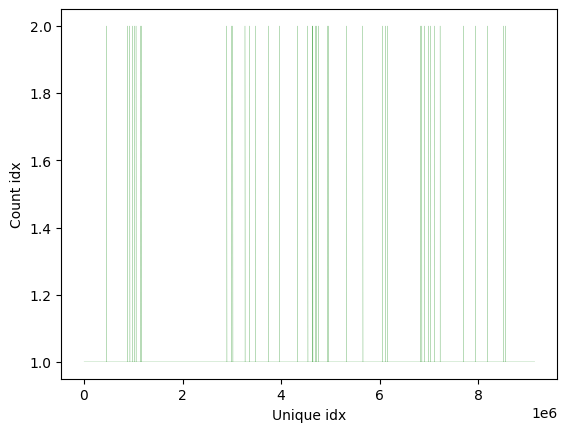

In [9]:
# TODO, plot wrt bins
plt.plot(uniques_idx, counts_idx, 'g', linewidth=0.1)
plt.xlabel("Unique idx")
plt.ylabel("Count idx")  # nb. data falling into bin
plt.show()

There are sometimes two data points in a bin, we can average the data falling into each bin (profile hist but without error bars).

In [10]:
t = bins[indices_digitized]

# First column is the quantized time, second is the 'average' rate within the bin
light_curve = np.array(pd.DataFrame(np.vstack([t, sum_fe_rate, indices_digitized]).T, 
                                    columns=["t", "sum_fe_rate", "idx"]).groupby("idx").mean())

In [11]:
t, y = light_curve.T

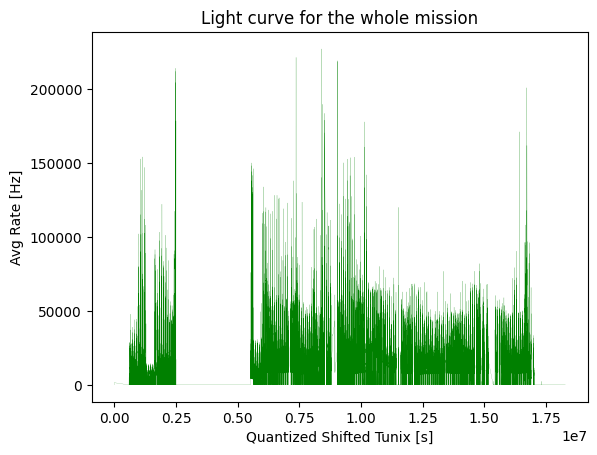

In [12]:
plt.plot(t, y, 'g', linewidth=0.1)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

Let's show just a small part of it (not the whole mission):

In [13]:
t.shape, y.shape

((6208160,), (6208160,))

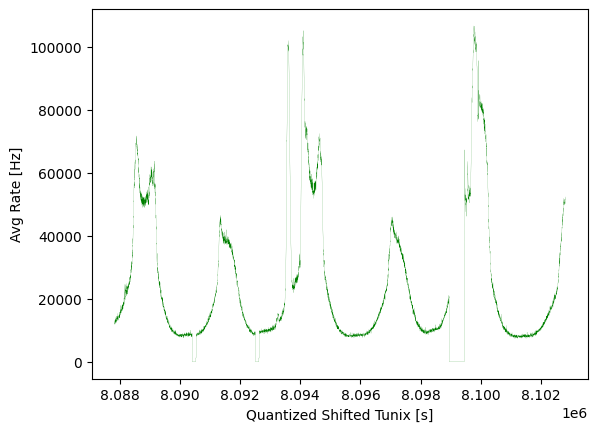

In [14]:
# Mask used to select a portion of the mission
mask = (t>(5000+1482032854-tunix_min)) & (t<(20000+1482032854-tunix_min))

plt.plot(t[mask], y[mask], '-g', linewidth=0.1)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.show()

---

## Fourier Transform

In [15]:
fft_res = np.fft.rfft(y)

In [16]:
freqs = np.fft.fftfreq(y.size, d=2)
freqs

array([ 0.00000000e+00,  8.05391614e-08,  1.61078323e-07, ...,
       -2.41617484e-07, -1.61078323e-07, -8.05391614e-08])

In [17]:
freqs[:y.size//2]

array([0.00000000e+00, 8.05391614e-08, 1.61078323e-07, ...,
       2.49999758e-01, 2.49999839e-01, 2.49999919e-01])

In [18]:
print(f"freqs[:y.size//2].size={freqs[:y.size//2].size}, fft_res.size={fft_res.size}")

freqs[:y.size//2].size=3104080, fft_res.size=3104081


In [19]:
mag = np.abs(fft_res)
phase = np.angle(fft_res)

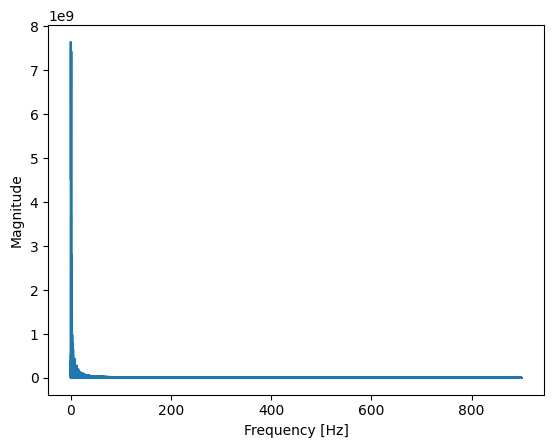

In [20]:
plt.plot(3600*freqs[1:y.size//2], mag[1:-1])
plt.xlabel("Frequency [Hz]")   # TODO change units ... per hour
plt.ylabel("Magnitude")
plt.show()

In [21]:
fft_res.size

3104081

In [22]:
t.size

6208160

In [23]:
1/(2*3600)*1e5

13.88888888888889

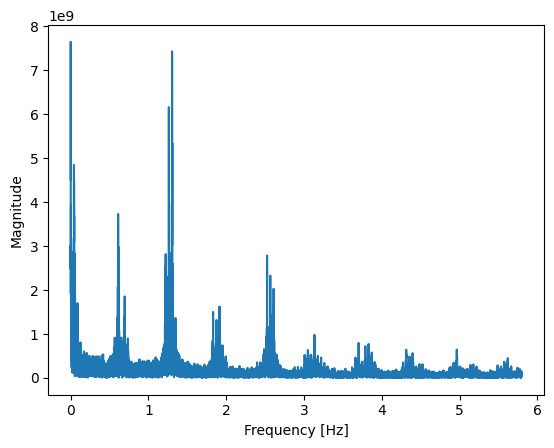

In [24]:
n = 20000
plt.plot(3600*freqs[:y.size//2][1:n], mag[1:n])
plt.xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
plt.ylabel("Magnitude")
plt.show()

## Convolution

In [25]:
mag_convolved = np.convolve(mag, np.ones(10)/10, "same")
# TODO: only do it for the big spikes and try with different window lengths
# TODO: be careful about padding !!

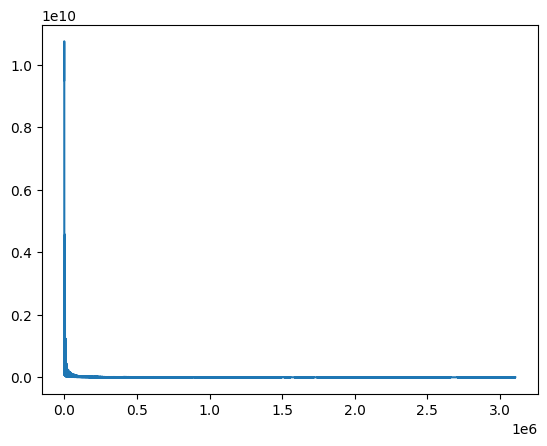

In [26]:
plt.plot(mag_convolved)

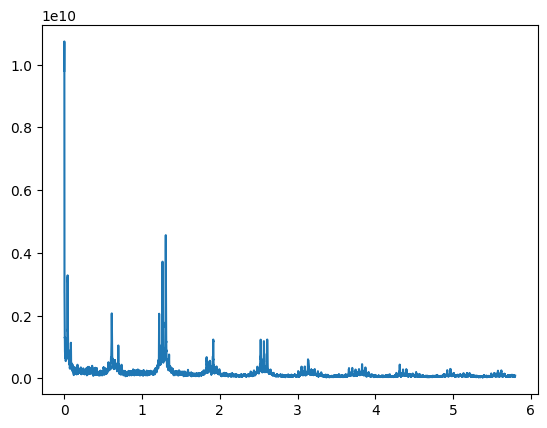

In [27]:
plt.plot(3600*freqs[:y.size//2][1:n], mag_convolved[1:n])

In [28]:
reconstructed = np.fft.irfft(mag_convolved*np.exp(1j*np.angle(fft_res)))

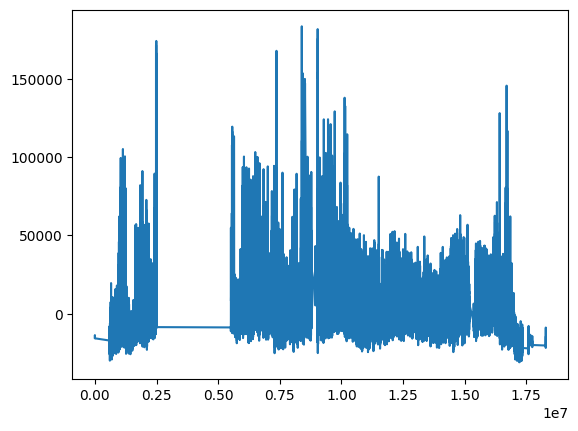

In [29]:
plt.plot(t, np.real(reconstructed))
plt.show()

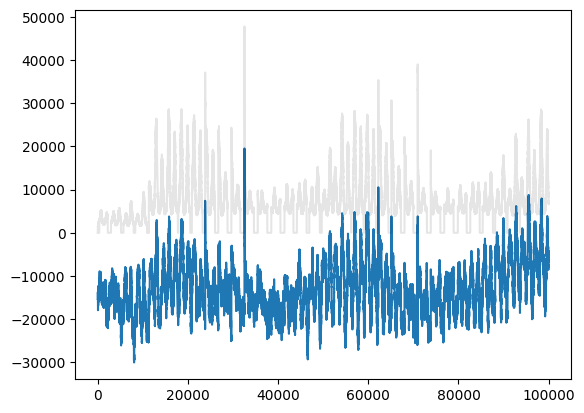

In [30]:
plt.plot(np.real(reconstructed)[:100000])
plt.plot(y[:100000], 'k', alpha=0.1)

In [31]:
fft_res.shape

(3104081,)

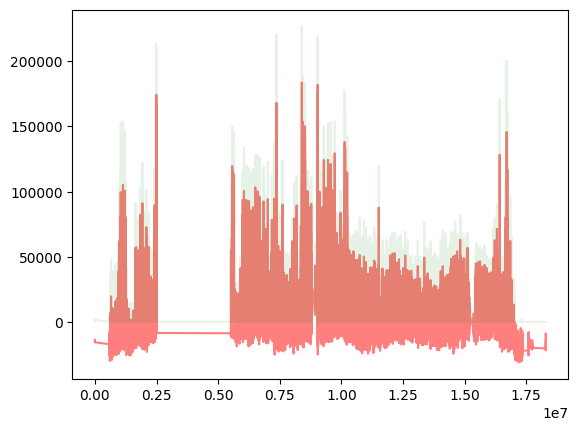

In [32]:
plt.plot(t, np.real(reconstructed), 'r', alpha=0.5)
plt.plot(t, y, 'g', alpha=0.1)

Values below zero doesn't make any sense physically (counts)

In [33]:
reconstructed.size

6208160

In [34]:
y.size

6208160

In [35]:
print(t.min(), t.max())  # TODO: need to take this into account 

2.0 18290974.0
